In [1]:
import requests
import datetime
import dateutil

In [2]:
def get_payments(campaign_id):
    url = "https://molamola.by/api/campaigns/{}/payments".format(campaign_id)
    res = []
    while url is not None:
        r = requests.get(url)
        if r.status_code != 200:
            if res != []:
                raise "some shit happend in the middle of {}".format(campaign_id)
            return []
        data = r.json()
        res.extend(data["data"])
        url = data["links"]["next"]
    return res

In [3]:
def percentage(sum):
    p = sum * 0.06
    return p if p > 1.1 else 1.1

In [4]:
def collect(f, t):
    pss = {}
    for c in range(f, t + 1):
        ps = get_payments(c)
        if len(ps) != 0:
            pss[c] = [{"date": dateutil.parser.parse(p["created_at"]).date(), "sum": p["sum"]} for p in ps]
    return pss

In [5]:
payments = collect(1, 4000)

In [6]:
df = {}
for c in payments.keys():
    for p in payments[c]:
        if p["date"] not in df:
            df[p["date"]] = {"payments": 0, "comissions": 0}
        df[p["date"]]["payments"] += p["sum"]
        df[p["date"]]["comissions"] += percentage(p["sum"])

In [7]:
sdates = []
spayments = []
scomissions = []

d = min(df.keys())
dt = max(df.keys())
while d < dt:
    d = d + datetime.timedelta(days=1)
    sdates.append(d)
    if d in df:
        spayments.append(df[d]["payments"])
        scomissions.append(df[d]["comissions"])
    else:
        spayments.append(0)
        scomissions.append(0)

In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

%matplotlib inline
%config InlineBackend.figure_format = "retina"

plt.rcParams["figure.figsize"] = (12, 8)
sns.set(style="darkgrid", color_codes=True)
sns.set_context("notebook", font_scale=1.0)

In [9]:
pdf = pd.DataFrame(zip(spayments, scomissions), columns=["сборы", "комиссия"], index=sdates)

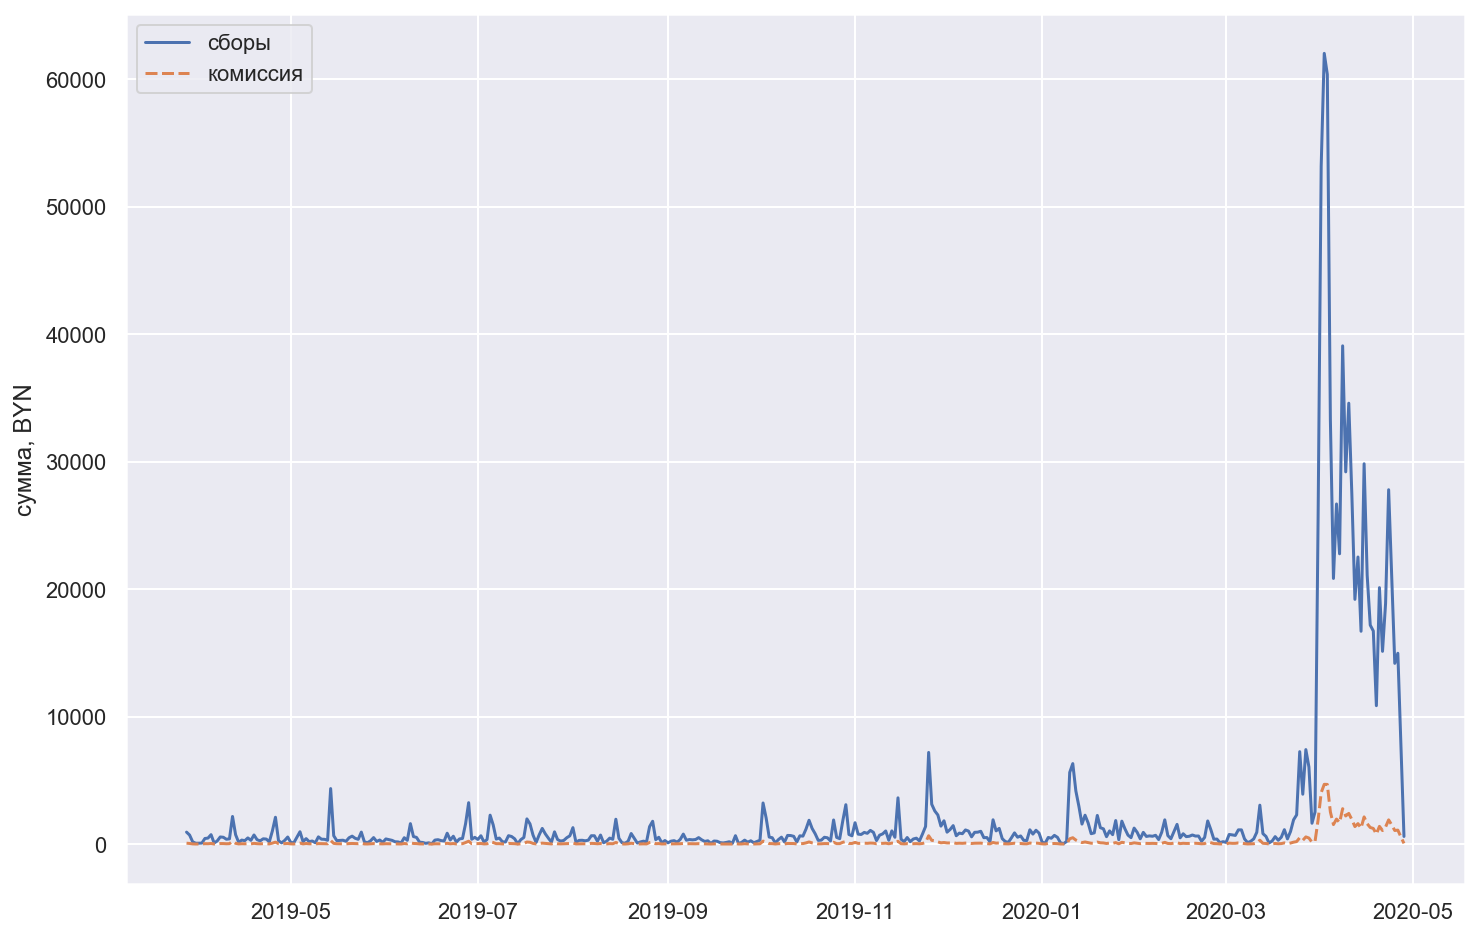

In [10]:
sns.lineplot(data=pdf)
plt.ylabel("сумма, BYN");

In [11]:
sum(spayments)

1022467

In [12]:
sum(scomissions)

76563.99999999952